# **Benetech - Making Graphs Accessible**
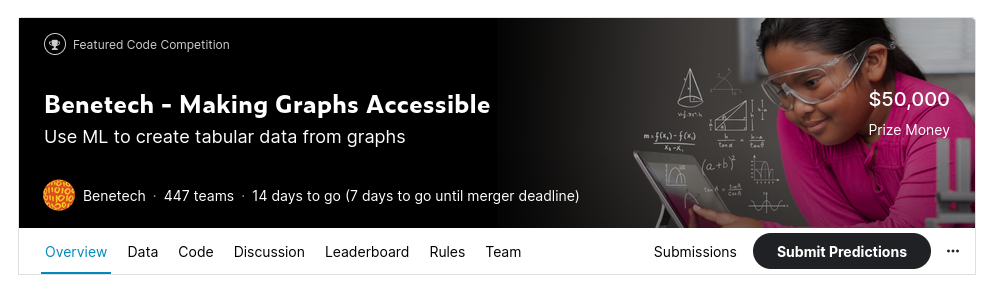
> <pre>@misc{benetech-making-graphs-accessible,
    author = {Benji Andrews, benjiaa, HCL-Rantig, Hema Natarajan, Maggie, Ryan Holbrook},
    title = {Benetech - Making Graphs Accessible},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/benetech-making-graphs-accessible}
} </pre>

In [1]:
!pip install git+https://github.com/huggingface/transformers --quiet
!pip install -U watermark accelerate==0.20.3 --quiet
!pip install -U datasets pyarrow polyleven -q
%load_ext watermark
%watermark -a 'NavinKumarMNK' -v -p torch,transformers,wandb


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Author: NavinKumarMNK

Python implementation: CPython
Python version       : 3.8.17
IPython version      : 8.12.2

torch       : 2.0.0
transformers: 4.31.0.dev0
wandb       : 0.12.21



In [2]:
!pip3 install pytorch_lightning polars albumentations --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## **Modules Import**

In [4]:
import pandas as pd
import polars as pol

import torch
import pytorch_lightning as pl
from transformers import Pix2StructForConditionalGeneration, AutoProcessor, Pix2StructConfig, get_linear_schedule_with_warmup 
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup, Adafactor

from PIL import Image
import os
import json
from pathlib import Path
from typing import List, Dict, Union
import pprint
pprint = pprint.pprint
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import warnings
warnings.simplefilter("ignore")

## **Configuration**

In [5]:
class Config:
    # General
    debug = False
    num_proc = 2
    num_workers = 2
    gpus = 2

    # Data
    data_dir = Path('/kaggle/input/benetech-making-graphs-accessible/train')
    images_path = data_dir/'images'
    train_json_files = list(data_dir.glob('annotations/*.json'))

    # Training
    epochs = 5
    val_check_interval = 1.0
    check_val_every_n_epoch = 1
    gradient_clip_val = 2.0
    lr = 2e-5
    lr_scheduler_type = "cosine"
    num_warmup_steps = 100
    seed = 42
    output_path = "output"
    log_steps = 200
    batch_size = 2
    use_wandb = True
    
    image_size = 512
    max_length = 512
    max_patches = 1024


## **Preprocessing Annotations**

In [6]:
PROMPT_TOKEN = "<|BOS|>"
X_START = "<x_start>"
X_END = "<x_end>"
Y_START = "<y_start>"
Y_END = "<y_end>"

SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    X_START,
    X_END,
    Y_START,
    Y_END,
]

LINE_TOKEN =  "<line>" 
VERTICAL_BAR_TOKEN = "<vertical_bar>"
HORIZONTAL_BAR_TOKEN = "<horizontal_bar>"
SCATTER_TOKEN = "<scatter>"
DOT_TOKEN = "<dot>"

CHART_TYPE_TOKENS = [
    LINE_TOKEN,
    VERTICAL_BAR_TOKEN,
    HORIZONTAL_BAR_TOKEN,
    SCATTER_TOKEN,
    DOT_TOKEN,
]

NEW_TOKENS = SEPARATOR_TOKENS + CHART_TYPE_TOKENS

In [7]:
class Preprocessor:
    def round_float(self, value: Union[int, float, str]) -> Union[str, float]:
        """
        @brief  : Convert float value into string => >1 digit in int => trunc. 1 decimal ,else trunc. 4 decimals
        @args   : value [int, float, str] : float value to convert
        @return : str : flat value as string
        """
        if isinstance(value, float):
            value = str(value)

            if '.' in value: 
                integer, decimal = value.split(".")
                if abs(float(integer)) > 1 :
                    decimal = decimal[:1]
                else:
                    decimal = decimal[:4]

                value = integer + "." + decimal

        return value
    
    def is_nan(self, value: Union[int, float, str]) -> bool:
        """
        @brief  : Check if value is NaN
        @args   : value [int, float, str] : value to check
        @return : bool : True if value is NaN, else False
        """
        if isinstance(value, str):
            return value.lower() == 'nan'
        return value != value
    
    
    def get_gt_string_and_xy(self, filepath: Union[str, os.PathLike]) -> Dict[str, str]:
        """
        @brief  : Get ground truth string and xy coordinates from filepath
        @args   : filepath [str, os.PathLike] : filepath to get gt string and xy coordinates
        @return : Dict[str, str] : gt string and xy coordinates
        """
        filepath = Path(filepath)
        with open(filepath) as fp:
            data = json.load(fp)
            
        data_series = data["data-series"]
        all_x, all_y = [], []

        for d in data_series:
            x, y = d["x"], d["y"]
            x, y = self.round_float(x), self.round_float(y)

            if self.is_nan(x) or self.is_nan(y):
                continue

            all_x.append(x)
            all_y.append(y)

        chart_type = f"<{data['chart-type']}>"
        x_str = X_START + ";".join(list(map(str, all_x))) + X_END
        y_str = Y_START + ";".join(list(map(str, all_y))) + Y_END

        gt_string = PROMPT_TOKEN + chart_type + x_str + y_str

        return {
            "ground_truth": gt_string,
            "x": json.dumps(all_x),
            "y": json.dumps(all_y),
            "chart-type": data["chart-type"],
            "id": filepath.stem,
            "source": data["source"],
        }
        

In [8]:
pprint(Preprocessor().get_gt_string_and_xy(Config.data_dir / "annotations" / "0000ae6cbdb1.json"))

{'chart-type': 'vertical_bar',
 'ground_truth': '<|BOS|><vertical_bar><x_start>Malawi;Malaysia;Maldives;Mali;Malta;Martinique;Mauritania;Mauritius;Mayotte;Melanesia<x_end><y_start>837799.9;960480.6;750170.9;697593.4;574912.8;452232.1;653778.9;539861.2;417180.5;574912.8<y_end>',
 'id': '0000ae6cbdb1',
 'source': 'generated',
 'x': '["Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Martinique", '
      '"Mauritania", "Mauritius", "Mayotte", "Melanesia"]',
 'y': '["837799.9", "960480.6", "750170.9", "697593.4", "574912.8", '
      '"452232.1", "653778.9", "539861.2", "417180.5", "574912.8"]'}


## **Dataset**

### **Non-Competition Dataset**

In [ ]:
df = pol.read_csv("/kaggle/input/benetech-extra-generated-data/metadata.csv")
graph_types = {
    "d":"dot",
    "h":"horizontal_bar",
    "s":"scatter",
    "l":"line",
    "v":"vertical_bar"
}


In [ ]:
def convert_extra_to_df(df):
    main_dct = {}
    try:
        for row in df.rows():
            dct = {}
            graph, image_id = row[0].split('/')
            graph_type = graph_types[graph.split("_")[1]]
            image_id = graph_type + "-" + image_id

            data_series = row[1].split(' <0x0A> ')
            _x = []
            _y = []
            for data in data_series:
                x, y = data.split(' | ')
                _x.append(x)
                _y.append(y)

            x_str = X_START + ";".join(list(map(str, _x))) + X_END
            y_str = Y_START + ";".join(list(map(str, _y))) + Y_END

            gt_string = PROMPT_TOKEN + '<'+graph_type+'>' + x_str + y_str

            dct['chart-type'] = graph_type
            dct['ground_truth'] = gt_string
            dct['id'] = image_id
            dct['source'] = 'extra'
            dct['x'] = _x
            dct['y'] = _y
            main_dct[image_id] = dct
    except Exception as e:
        print(e, row)
            
    df_new = pd.DataFrame.from_dict(main_dct, orient='index')
    return df_new       


In [ ]:
df_old = convert_extra_to_df(df)
df_old.head()

### **Competition Dataset**

In [ ]:
dct = {}
pre = Preprocessor()
for no, i in enumerate(Config.train_json_files):
    j = pre.get_gt_string_and_xy(i)
    dct[j['id']+'.jpg'] = j

df_new = pd.DataFrame.from_dict(dct, orient='index')
df_new.head()


In [ ]:
df_old = df_old.reindex(columns=df_new.columns)
train_df = pd.concat([df_old, df_new], axis=0)
train_df['path'] = train_df.index
train_df

In [ ]:
train_df.reset_index(inplace=True)
train_df = train_df[['chart-type', 'ground_truth', 'source', 'path']]
data_1 = train_df[train_df['source']!='extra']
data_2 = train_df[train_df['source']=="extra"]


In [ ]:
count = [24942, 19189, 11243, 5131, 73]
graphs = ["line", "vertical_bar", "scatter", "dot", "horizontal_bar"]

In [ ]:
sample_df = pd.DataFrame()

for (i, chart_type) in enumerate(graphs):
    if count[i] > 10000:
        print(count[i])
        main_rows = data_1[data_1['chart-type'] == chart_type]
        sample_main_rows = main_rows.sample(n=10000)
        count[i] = 10000
    else :
        main_rows = data_1[data_1['chart-type'] == chart_type]
        sample_main_rows = main_rows.sample(n=count[i])
        count[i] = 20000 - count[i]
    
    second_rows = data_2[data_2['chart-type'] == chart_type]
    sample_second_rows = second_rows.sample(n=count[i])
    
    sample_df = pd.concat([sample_df, sample_main_rows], axis=0)
    sample_df = pd.concat([sample_df, sample_second_rows], axis=0)
    
sampled_df = sample_df.reset_index(drop=True)

In [ ]:
data = sampled_df.to_dict(orient='records')
with open('train_data.json', 'w') as f:
    json.dump(data, f)

In [ ]:
val_df = train_df[train_df['source']=='extracted']
val_df = pd.concat([val_df, train_df[train_df['chart-type']=='dot'].sample(300)], axis=0)
val_df = val_df[['chart-type', 'ground_truth', 'source', 'path']]
val_df = val_df.rename_axis(None)
val_df = val_df.reset_index()[['chart-type', 'ground_truth', 'source', 'path']]
val_df

In [ ]:
data = val_df.to_dict(orient='records')
with open('val_data.json', 'w') as f:
    json.dump(data, f)

## **Model**

In [9]:
model = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-base")
processor = AutoProcessor.from_pretrained("google/matcha-base", is_vqa=False)

In [10]:
processor.image_processor.size = {
        "height": Config.image_size,
        "width": Config.image_size,
}

In [ ]:
image_path = "/kaggle/input/benetech-extra-generated-data/graphs_d/0.jpg"
image = Image.open(image_path)

In [11]:
with open("/kaggle/input/benetech-metadata/train_data(2).json", "r") as fl:
    train_dataset = json.load(fl)
    
with open("/kaggle/input/benetech-metadata/val_data(1).json", "r") as fl:
    val_dataset = json.load(fl)


In [12]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    texts = list(examples['ground_truth'].values())
    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]
    
    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)
    return {"unk_tokens": unk_tokens}

In [ ]:
unk = pd.DataFrame(check_for_unk(train_df.to_dict()))
unk = unk.loc[unk["unk_tokens"].apply(len) > 0]



In [13]:
example_str = train_dataset[0]['ground_truth']
temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
num_added = processor.tokenizer.add_tokens(["\n"] + NEW_TOKENS)
model.resize_token_embeddings(len(processor.tokenizer))
print(len(processor.tokenizer))
print(num_added, "tokens added")

processor.eos_token_id = processor.tokenizer.convert_tokens_to_ids(["<Y_END>"])[0]
processor.bos_token_id  = processor.tokenizer.convert_tokens_to_ids(["<|BOS|>"])[0]
model.config.eos_token_id = processor.eos_token_id
model.config.bos_token_id = processor.bos_token_id

ids: [411, 957, 736, 7688, 957, 820, 2188, 820, 567, 326, 4923, 371, 277, 292, 295, 293, 324, 277, 292, 295, 295, 324, 277, 292, 295, 294, 324, 277, 292, 295, 292, 324, 277, 292, 294, 278, 324, 277, 292, 294, 277, 324, 277, 292, 294, 279, 324, 277, 292, 294, 285, 324, 277, 292, 294, 289, 324, 277, 292, 294, 290, 324, 277, 292, 294, 293, 324, 277, 292, 294, 295, 324, 277, 292, 294, 294, 324, 277, 292, 294, 292, 589, 567, 326, 2658, 820, 506, 326, 4923, 371, 277, 278, 290, 274, 290, 324, 277, 278, 293, 274, 289, 324, 277, 278, 295, 274, 278, 324, 277, 278, 290, 274, 294, 324, 277, 278, 293, 274, 285, 324, 277, 278, 279, 274, 292, 324, 277, 278, 289, 274, 289, 324, 277, 278, 289, 274, 277, 324, 277, 278, 289, 274, 285, 324, 277, 278, 289, 274, 292, 324, 277, 278, 290, 274, 290, 324, 277, 278, 293, 274, 285, 324, 277, 278, 290, 274, 292, 324, 277, 278, 293, 274, 295, 589, 506, 326, 2658, 371, 1]
tokenized: ['▁<', '|', 'B', 'OS', '|', '><', 'line', '><', 'x', '_', 'start', '>', '1', '9', '7

## **Training**

In [14]:
graph_types_rev = {
    "dot":"d",
    "horizontal_bar":"h",
    "scatter":"s",
    "line":"l",
    "vertical_bar":"v"
}

def augments():
        return A.Compose([
            A.Resize(width=Config.image_size, height=Config.image_size),
            A.Normalize(
                mean=[0, 0, 0], 
                std=[1, 1, 1],
                max_pixel_value=255,
            ),
            ToTensorV2(),
        ])


class BeneTechDataset(TorchDataset):
    def __init__(self, dataset, processor, ):
        self.dataset = dataset
        self.processor = processor
        self.augmenter = augments()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx] 
        if item['source'] == 'extra':
            path = "/kaggle/input/benetech-extra-generated-data/"
            path = path + "graphs_" + graph_types_rev[item['chart-type']] + "/"
            path = path + item['path'].split('-')[-1]
        else:
            path = "/kaggle/input/benetech-making-graphs-accessible/train/images/"
            path = path + item['path']

        
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.augmenter(image=image)['image']
        encoding = self.processor(
            images=torch.Tensor(image),
            return_tensors="pt", 
            add_special_tokens=True, 
            max_patches=Config.max_patches
        )

        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item['ground_truth']
        
        return encoding


class BeneTechDataModule(pl.LightningDataModule):
    def __init__(self, dataset, val_dataset, processor, batch_size, num_workers):
        super().__init__()
        self.dataset = dataset
        self.val_dataset = val_dataset
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = BeneTechDataset(self.dataset, self.processor)
        self.val_dataset = BeneTechDataset(self.val_dataset, self.processor)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=True,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        new_batch = {"flattened_patches": [], "attention_mask": []}
        texts = [item["text"] for item in batch]
        encoding = self.processor(
            text=texts,
            return_tensors="pt", 
            padding="max_length", 
            truncation=True, 
            add_special_tokens=True,
            max_length=Config.max_length
        )
        new_batch["labels"] = encoding.input_ids
        for item in batch:
            new_batch["flattened_patches"].append(item["flattened_patches"])
            new_batch["attention_mask"].append(item["attention_mask"])
        new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
        new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])
        return new_batch



In [15]:
class MatChaFineTuned(pl.LightningModule):
    def __init__(self, processor,
                    model,
                    model_path:str=None,):
        super(MatChaFineTuned, self).__init__()
        
        self.processor = processor
        self.model = model
        self.model_path = model_path  
        self.val_loss = []
        
    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx:int) -> torch.Tensor:
        labels = batch['labels']
        flattened_patches = batch['flattened_patches']
        attention_mask = batch['attention_mask']
        outputs = self.model(
            flattened_patches=flattened_patches, 
            attention_mask=attention_mask, 
            labels=labels)
        loss = outputs.loss
        self.log('train_loss', loss)
        return loss
            
    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx:int) -> None:
        labels = batch['labels']
        flattened_patches = batch['flattened_patches']
        attention_mask = batch['attention_mask']
        outputs = self.model(
                flattened_patches=flattened_patches, 
                attention_mask=attention_mask, 
                labels=labels)
        loss = outputs.loss
        self.val_loss.append(loss)
        self.log('val_loss', loss)
        return {"val_loss":loss}
    
    def on_validation_epoch_end(self)-> None:
        avg_loss = torch.stack([x for x in self.val_loss]).mean()
        self.log('val/loss_epoch', avg_loss)
        self.log('val/loss', avg_loss, prog_bar=True)
        self.val_loss = []
    
            
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0, last_epoch=-1)
        return [optimizer], [scheduler]

    def save_model(self):
        torch.save(self.model, self.model_path+'.pt')

In [16]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import callbacks as pl_callbacks

wandb_logger = WandbLogger(project="matcha", name="matcha")
wandb_logger.watch(model, log='all', log_freq=100)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: mnk. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [17]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [18]:
model_train = MatChaFineTuned(
    processor=processor,
    model=model,
    model_path="/kaggle/working/matcha",
)

dataset = BeneTechDataModule(train_dataset, val_dataset, processor, batch_size=2, num_workers=2)
dataset.setup()

callbacks = [
    pl_callbacks.ModelCheckpoint(
        monitor='val_loss',
        dirpath='/kaggle/working/checkpoints',
        filename='matcha-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min',
    ),
    pl_callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
    ),
    pl_callbacks.LearningRateMonitor(logging_interval='epoch'),
    pl_callbacks.TQDMProgressBar(),
]

In [ ]:
trainer = pl.Trainer(
    accelerator="cuda",
    max_epochs=10,
    devices=2,
    callbacks=callbacks,
    logger=wandb_logger,
    log_every_n_steps=1,
    limit_train_batches=0.1,
    accumulate_grad_batches=8,
    num_sanity_val_steps=10,
    precision=16,
)

trainer.fit(model_train, train_dataloaders=dataset.train_dataloader(),
            val_dataloaders=dataset.val_dataloader())


In [ ]:
model.save_pretrained("/kaggle/working/deplot.pt")
processor.save_pretrained("/kaggle/working/deplot.pt")

In [ ]:
image_path = "/kaggle/input/benetech-making-graphs-accessible/test/images/01b45b831589.jpg"
image = Image.open(image_path)
plt.imshow(image)

In [ ]:
%%time
model.cuda()
with torch.no_grad():
    inputs = processor(images=image,
                      return_tensors="pt").to(device="cuda")
    predictions = model.generate(**inputs, max_new_tokens=512,
                                early_stopping=True, use_cache=True,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                bos_token_id=processor.tokenizer.bos_token_id,
                                decoder_start_token_id=processor.tokenizer.bos_token_id)
    print(processor.decode(
        predictions[0], skip_special_tokens=True
    ))

In [ ]:
model1 = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot.pt")
processor1 = AutoProcessor.from_pretrained("/kaggle/working/deplot.pt", is_vqa=False)

In [ ]:
%%time
model1.cuda()
with torch.no_grad():
    inputs = processor1(images=image,
                      return_tensors="pt").to(device="cuda")
    predictions = model1.generate(**inputs, max_new_tokens=512,
                                early_stopping=True, use_cache=True,
                                eos_token_id=processor1.tokenizer.eos_token_id,
                                pad_token_id=processor1.tokenizer.pad_token_id,
                                bos_token_id=processor1.tokenizer.bos_token_id,
                                decoder_start_token_id=processor1.tokenizer.bos_token_id)
    print(processor1.decode(
        predictions[0], skip_special_tokens=False
    ))